# Profast Data Analysis

This notebook is divided into two main sections:
1. [Data and Correlation Analysis and Preprocessing](#data_analysis)
2. [Machine Learning for CGM Prediction](#machine_learning)

<a id='data_analysis'></a>
## 1. Data and Correlation Analysis and Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from dataprep.eda import create_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tasrif.data_readers.siha_dataset import \
    SihaSleepDataset, \
    SihaStepsIntradayDataset, \
    SihaCaloriesIntradayDataset, \
    SihaDistanceIntradayDataset, \
    SihaHeartRateIntradayDataset, \
    SihaVeryActiveMinutesDataset, \
    SihaLightlyActiveMinutesDataset, \
    SihaSedentaryMinutesDataset, \
    SihaModeratelyActiveMinutesDataset, \
    SihaTimeInHeartRateZonesDataset, \
    SihaStepsDataset, \
    SihaCaloriesDataset, \
    SihaDistanceDataset, \
    SihaCgmDataset, \
    SihaEmrDataset, \
    SihaSleepIntradayDataset

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


The following location is where I mounted the driver in my computer.
Change it accordingly.

In [2]:
profast_datapath='../../data/profast2020/'

Below, we defined a set of helper functions for the analysis.
Some of them could be eventually integrated back to Tasrif

In [13]:
# Helper functions
def read_data(module, class_name_mapping, datapath=profast_datapath):

    ds = module(folder=datapath)

    df_tmp = ds.processed_dataframe()
    df_tmp = df_tmp.reset_index()

    if "time" not in df_tmp:
        df_tmp = df_tmp.rename(columns={"dateTime": "time"})

    df_tmp = df_tmp.rename(columns={"value": class_name_mapping[module]})
    return df_tmp


def ramadan_flag(t, start_ramadan=pd.Timestamp(2020, 4, 23, 0, 0, 0),
                 end_ramadan=pd.Timestamp(2020, 5, 23, 23, 59, 59)):

    if (t >= start_ramadan) & (t <= end_ramadan):
        return 1
    elif t < start_ramadan:
        return 0
    else:
        return 2

def get_participant(df, pid):
    return df[df["patientID"] == pid]

def get_before_ramadan(df):
    return df[df["Ramadan"] == 0]

def get_ramadan(df):
    return df[df["Ramadan"] == 1]

def corr_per_day(df):
    return df.groupby(pd.Grouper(key='time',freq='D'))[["Calories", "mets", "Steps", "Distance", "CGM"]].corr()

def get_data_day(df, month, day, time_col="time"):
    return df[(df[time_col].dt.month == month) & (df[time_col].dt.day == day)]

def drop_days_below_min_steps(df, min_steps=1000, time_col="time", pid_col="patientID"):
    # Get number of steps in a day
    total_steps_day = df.groupby([pid_col, pd.Grouper(key=time_col,freq='D')])["Steps"].sum()

    # Find the <pids, days> to drop
    days_to_drop = total_steps_day[total_steps_day <= min_steps].index

    # Temporarily reindex dataframe with <pid, day>
    df_tmp = df.set_index([pid_col, df[time_col].dt.floor("D")])

    # Return only the <pids, days> that are not in the list to drop
    df_tmp = df_tmp.loc[~df_tmp.index.isin(days_to_drop)]

    # The first level of index (pid) needs to come back to the dataframe, but the second one (day) have to be dropped
    return df_tmp.reset_index(level=0).reset_index(drop=True)


def agg_per_day(df, metric, operation, outputcol_name=None, pid_col="patientID", time_col="time", 
                remove_zero_steps=False):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0]
    else:
        df_tmp = df.copy()

    # Get aggregated number of [steps, calories, ...] in a day 
    metric_per_day = df_tmp.groupby([pid_col, pd.Grouper(key=time_col,freq='D')])[metric].agg(operation)
    if outputcol_name is not None:
        metric_per_day.name = outputcol_name
    return metric_per_day

def sum_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "sum", outputcol_name, pid_col, time_col, remove_zero_steps)

def mean_per_day(df, metric, outputcol_name=None, pid_col="patientID", time_col="time", remove_zero_steps=False):
    return agg_per_day(df, metric, "mean", outputcol_name, pid_col, time_col, remove_zero_steps)

def is_mild_hypo(cgm_value):
    if cgm_value <= 70: 
        return 1
    return 0

def is_severe_hypo(cgm_value):
    if cgm_value <= 54: 
        return 1
    return 0

def is_hyper(cgm_value):
    if cgm_value >= 180: 
        return 1
    return 0

def hyper_hypo_label(cgm_value):
    if is_hyper(cgm_value):
        return 1
    elif is_hypo(cgm_value):
        return 2
    return 0

### First Goal: Combining intra day data

The cells below aim to combine the intra day FitBit and CGM data

In [7]:
class_name_mapping = {SihaCaloriesIntradayDataset: "Calories",
                      SihaStepsIntradayDataset: "Steps",
                      SihaDistanceIntradayDataset: "Distance",
                      SihaHeartRateIntradayDataset: "HeartRate",
                      SihaCgmDataset: "CGM"
}

# Read HR data:
df_intra = read_data(SihaHeartRateIntradayDataset, class_name_mapping)
# Resample to 15 min intervals
df_intra = df_intra.groupby("patientID")[["HeartRate", "time"]].resample(rule="15min",
                                                                         offset='00h00min',
                                                                         on="time").mean().reset_index()

for intraday_module in [SihaCaloriesIntradayDataset, SihaStepsIntradayDataset,
                         SihaDistanceIntradayDataset]:

    df_tmp = read_data(intraday_module, class_name_mapping)
    df_intra = pd.merge(df_intra, df_tmp, on=['patientID', 'time'], how='outer')

df_intra = df_intra.dropna()
df_intra.head(10)

patientID                time  HeartRate  level   mets   Calories  Steps  \
0         27 2020-02-16 10:45:00  79.733330    1.0  389.0  52.581131  348.0   
1         27 2020-02-16 11:00:00  80.199997    1.0  440.0  59.474800  412.0   
2         27 2020-02-16 11:15:00  78.000000    1.0  328.0  44.335758  179.0   
3         27 2020-02-16 11:30:00  74.599998    1.0  256.0  34.603519   67.0   
4         27 2020-02-16 11:45:00  81.333336    1.0  420.0  56.771400  333.0   
5         27 2020-02-16 12:00:00  82.000000    1.0  395.0  53.392151  312.0   
6         27 2020-02-16 12:15:00  77.666664    1.0  230.0  31.089100    8.0   
7         27 2020-02-16 12:30:00  90.466667    1.0  572.0  77.317238  529.0   
8         27 2020-02-16 12:45:00  94.400002    1.0  432.0  58.393440  331.0   
9         27 2020-02-16 13:00:00  94.400002    1.0  417.0  56.365891  207.0   

   Distance  
0  0.167646  
1  0.198404  
2  0.086122  
3  0.032249  
4  0.160376  
5  0.150248  
6  0.003853  
7  0.254700  
8  0.159444  
9  0.099606

Following, we sync'ed the CGM data on a 15min interval round on the hour (i.e., HH:00, HH:15, HH:30, HH:45)

In [8]:
# The sample interval from the CGM device is very unstable.
df_cgm = read_data(SihaCgmDataset, class_name_mapping)

In [9]:
# Let's have a look at the data for a given patient 
df_sample = df_cgm[df_cgm["patientID"] == 27]
df_sample.sort_values(by=["time"]).head(20)
# note how there is a big jump from 12:17 to 15:19 for pid 27

time  patientID    CGM  manual
2209 2020-02-16 11:53:00         27   98.0   False
2211 2020-02-16 11:56:00         27  107.0    True
2217 2020-02-16 12:07:00         27   97.0   False
2218 2020-02-16 12:08:00         27   40.0    True
2221 2020-02-16 12:15:00         27   40.0    True
2223 2020-02-16 12:17:00         27   40.0    True
2280 2020-02-16 15:19:00         27  284.0    True
2282 2020-02-16 15:21:00         27  281.0   False
2287 2020-02-16 15:33:00         27  283.0    True
2289 2020-02-16 15:36:00         27  267.0   False
2296 2020-02-16 15:51:00         27  254.0   False
2299 2020-02-16 15:56:00         27  246.0    True
2303 2020-02-16 16:06:00         27  235.0   False
2311 2020-02-16 16:21:00         27  211.0   False
2313 2020-02-16 16:25:00         27  202.0    True
2319 2020-02-16 16:36:00         27  191.0   False
2325 2020-02-16 16:52:00         27  171.0   False
2329 2020-02-16 16:59:00         27  162.0    True
2332 2020-02-16 17:07:00         27  167.0   False
2334 2020-02-16 17:09:00         27  176.0    True

We force the data to have a 15 min pattern using the mean of all values inside the 15 win.
That is important for the data alignment for the rest of this work

In [10]:
df_cgm = df_cgm.groupby("patientID")[["CGM", "time"]].resample(rule="15min", offset='00h00min',
                                                               on="time").mean().reset_index()

df_cgm.sort_values(by=["patientID", "time"]).head(20)

patientID                time    CGM
0          27 2020-02-16 11:45:00  102.5
1          27 2020-02-16 12:00:00   68.5
2          27 2020-02-16 12:15:00   40.0
3          27 2020-02-16 12:30:00    NaN
4          27 2020-02-16 12:45:00    NaN
5          27 2020-02-16 13:00:00    NaN
6          27 2020-02-16 13:15:00    NaN
7          27 2020-02-16 13:30:00    NaN
8          27 2020-02-16 13:45:00    NaN
9          27 2020-02-16 14:00:00    NaN
10         27 2020-02-16 14:15:00    NaN
11         27 2020-02-16 14:30:00    NaN
12         27 2020-02-16 14:45:00    NaN
13         27 2020-02-16 15:00:00    NaN
14         27 2020-02-16 15:15:00  282.5
15         27 2020-02-16 15:30:00  275.0
16         27 2020-02-16 15:45:00  250.0
17         27 2020-02-16 16:00:00  235.0
18         27 2020-02-16 16:15:00  206.5
19         27 2020-02-16 16:30:00  191.0

Merge the whole intraday data

In [11]:
df_intra = pd.merge(df_intra, df_cgm)
df_intra.sort_values(by=["patientID", "time"]).head(20)

patientID                time   HeartRate  level    mets    Calories  \
0          27 2020-02-16 11:45:00   81.333336    1.0   420.0   56.771400   
1          27 2020-02-16 12:00:00   82.000000    1.0   395.0   53.392151   
2          27 2020-02-16 12:15:00   77.666664    1.0   230.0   31.089100   
3          27 2020-02-16 12:30:00   90.466667    1.0   572.0   77.317238   
4          27 2020-02-16 12:45:00   94.400002    1.0   432.0   58.393440   
5          27 2020-02-16 13:00:00   94.400002    1.0   417.0   56.365891   
6          27 2020-02-16 13:15:00   92.666664    1.0   380.0   51.364601   
7          27 2020-02-16 13:30:00  107.571426    2.0   659.0   89.077026   
8          27 2020-02-16 13:45:00  118.599998    3.0  1100.0  148.686996   
9          27 2020-02-16 14:00:00   82.800003    1.0   347.0   46.903992   
10         27 2020-02-16 14:15:00  103.333336    1.0   591.0   79.885468   
11         27 2020-02-16 14:30:00   83.800003    0.0   177.0   23.925091   
12         27 2020-02-16 14:45:00   72.466667    0.0   175.0   23.654751   
13         27 2020-02-16 15:00:00   97.866669    1.0   282.0   38.117939   
14         27 2020-02-16 15:15:00   98.866669    1.0   417.0   56.365891   
15         27 2020-02-16 15:30:00   87.266670    1.0   245.0   33.116650   
16         27 2020-02-16 15:45:00   94.533333    0.0   205.0   27.709850   
17         27 2020-02-16 16:00:00   86.666664    1.0   229.0   30.953930   
18         27 2020-02-16 16:15:00   86.866669    1.0   340.0   45.957802   
19         27 2020-02-16 16:30:00   88.533333    1.0   343.0   46.363312   

    Steps  Distance    CGM  
0   333.0  0.160376  102.5  
1   312.0  0.150248   68.5  
2     8.0  0.003853   40.0  
3   529.0  0.254700    NaN  
4   331.0  0.159444    NaN  
5   207.0  0.099606    NaN  
6   244.0  0.117439    NaN  
7     0.0  0.000000    NaN  
8   579.0  0.278871    NaN  
9   174.0  0.083761    NaN  
10  248.0  0.119428    NaN  
11    0.0  0.000000    NaN  
12    8.0  0.003853    NaN  
13  126.0  0.060646    NaN  
14  293.0  0.140927  282.5  
15  125.0  0.060211  275.0  
16   27.0  0.012987  250.0  
17   53.0  0.025476  235.0  
18  320.0  0.154100  206.5  
19  296.0  0.142480  191.0

Next, we add a Ramadan annotation. The ramadan date can be adjusted if wrongly set.

In [12]:
df_intra["Ramadan"] = df_intra["time"].apply(ramadan_flag)

Augment dataset with Hypo/Hyper annotations

In [13]:

df_intra["hypo"] = df_intra["CGM"].apply(lambda x: is_mild_hypo(x))
df_intra["shypo"] = df_intra["CGM"].apply(lambda x: is_severe_hypo(x))
df_intra["hyper"] = df_intra["CGM"].apply(lambda x: is_hyper(x))

### Data cleaning

Next, we are going to perform a few data cleaning procedures.
Note that a large number of epochs (almost 43% of all FitBit datapoints) miss the corresponding CGM data.
As we are going to later predict CGM, we will now drop invalid CGM data instead of imputing it.

In [14]:
df_cleaned = df_intra.copy()

In [15]:
print("Initial number of participants: %d" % df_cleaned["patientID"].unique().shape[0])
print("Total number of epochs: %d" % df_cleaned.shape[0])
print("Total number of epochs without CGM: %d (%.2f%% of total)" % (df_cleaned["CGM"].isnull().sum(),
                                                                    100.* df_cleaned["CGM"].isnull().sum()/df_intra.shape[0]))

print("--- Removing invalid CGM epochs....")
df_cleaned = df_cleaned.dropna()
print("\t* Remaining number of epochs: %d" % df_cleaned.shape[0])

print("--- Removing days in which number of steps is smaller than 1000 (for the whole day)")
df_cleaned = drop_days_below_min_steps(df_cleaned)

print("\t* Remaining number of epochs: %d" % df_cleaned.shape[0])

Initial number of participants: 35
Total number of epochs: 93497
Total number of epochs without CGM: 40142 (42.93% of total)
--- Removing invalid CGM epochs....
	* Remaining number of epochs: 53355
--- Removing days in which number of steps is smaller than 1000 (for the whole day)
	* Remaining number of epochs: 48609


To be able to better understand the data that we have, we verify how many valid days we have previously, during and after ramadan.

In [16]:
# Table: how many pre-ramadan, during ramadan, post-ramadan per user we have
rows = []
for pid in df_cleaned["patientID"].unique():
    df_tmp = df_cleaned[df_cleaned["patientID"] == pid]
    row = {}
    row["pid"] = pid
    row["before"] = df_tmp[(df_tmp["Ramadan"] == 0)]["time"].dt.floor("d").unique().shape[0]
    row["during"] = df_tmp[(df_tmp["Ramadan"] == 1)]["time"].dt.floor("d").unique().shape[0]
    row["after"] = df_tmp[(df_tmp["Ramadan"] == 2)]["time"].dt.floor("d").unique().shape[0]
    row["total"] = row["before"] + row["during"] + row["after"]
    rows.append(row)

data_availability = pd.DataFrame(rows)
data_availability


pid  before  during  after  total
0    27       5       0      0      5
1    31      13       0      0     13
2    32      13       8      0     21
3    34      15       0      0     15
4    37       1       0      0      1
5    39       7      12      0     19
6    41      11      13      0     24
7    44       1       0      0      1
8    46      34       0      0     34
9    48      40      22      0     62
10   49       7       1      0      8
11   50      31      14      0     45
12   51       4       0      0      4
13   53       6      14      0     20
14   54      10      13      0     23
15   55      15      15      0     30
16   56       7       0      0      7
17   57      10       4      0     14
18   58      12      11      0     23
19   60      10       0      0     10
20   65       2       0      0      2
21   67       3      12      0     15
22   71      15      13      0     28
23   72       6       0      0      6
24   74       4       0      0      4
25   75       6       9      0     15
26   78       2       0      0      2
27   79      14      20      0     34
28   80       1       0      0      1
29   81      35      24      0     59
30   82      11       1      0     12
31   83       7       3      0     10
32   84       8       0      0      8
33   85      44      31      0     75

    #Days  #Users
0       0      34
1       1      19
2       2      17
3       3      17
4       4      15
5       5      14
6       6      14
7       7      12
8       8      11
9       9      10
10     10      10


<AxesSubplot:xlabel='#Days'>

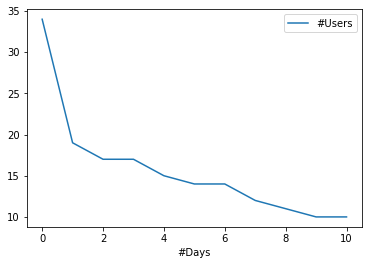

In [17]:
amount_of_days = 5

rows = []
for amount_of_days in range(0, 11):
        remaining = data_availability[(data_availability["before"] >= amount_of_days) & (data_availability["during"] >= amount_of_days)]
        row = {}
        row["#Days"] = amount_of_days
        row["#Users"] = remaining.shape[0]
        rows.append(row)
r = pd.DataFrame(rows)
print(r)
r.plot(x="#Days")

In [18]:
amount_of_days = 5
good_avail = data_availability[(data_availability["before"] >= amount_of_days) & (data_availability["during"] >= amount_of_days)]
good_avail

pid  before  during  after  total
2    32      13       8      0     21
5    39       7      12      0     19
6    41      11      13      0     24
9    48      40      22      0     62
11   50      31      14      0     45
13   53       6      14      0     20
14   54      10      13      0     23
15   55      15      15      0     30
18   58      12      11      0     23
22   71      15      13      0     28
25   75       6       9      0     15
27   79      14      20      0     34
29   81      35      24      0     59
33   85      44      31      0     75

Keep only participants with good data avilability

In [19]:
print("Total number of epochs so far: %d" % df_cleaned.shape[0])
df_cleaned = df_cleaned[df_cleaned["patientID"].isin(good_avail["pid"].to_list())]
print("\t* Remaining number of epochs: %d" % df_cleaned.shape[0])
print("\t* Remaining number of participants: %d" % df_cleaned["patientID"].unique().shape[0])

print("More than 5 days both before and during ramadan for %d participants." % (good_avail.shape[0]))
print("Ids: %s" % good_avail["pid"].to_list())


Total number of epochs so far: 48609
	* Remaining number of epochs: 37023
	* Remaining number of participants: 14
More than 5 days both before and during ramadan for 14 participants.
Ids: [32, 39, 41, 48, 50, 53, 54, 55, 58, 71, 75, 79, 81, 85]


### Data Viz

Unfortunately, simple matplotlib/pandas viz do not work properly, as we have two separated data periods, as we can see by the example below:

<AxesSubplot:xlabel='time'>

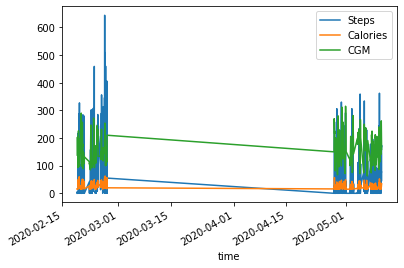

In [20]:
d = get_participant(df_cleaned, 39)
d.plot(x="time", y=["Steps", "Calories", "CGM"])

Alternatively, we can split the data into two different dataframes (df_before_ramanda and df_ramadan) and analyse them separately with dataprep, for example:

In [21]:
df_before_ramadan = corr_per_day(get_before_ramadan(d))
df_ramadan = corr_per_day(get_ramadan(d))

I could not spot any clear difference between the datasets:

  0%|          | 0/1644 [00:00<?, ?it/s]

DataPrep Report
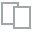
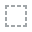
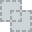
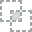
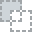
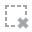
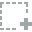
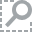
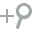
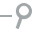
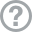
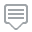
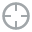
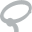
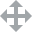
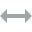
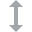
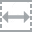
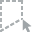
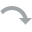
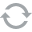
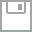
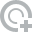
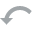
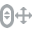
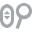
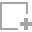
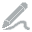
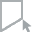
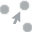
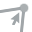
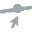

In [22]:
df_ramadan = get_before_ramadan(df_cleaned).reset_index(drop=True)
if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

  0%|          | 0/1644 [00:00<?, ?it/s]

DataPrep Report
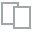
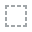
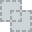
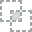
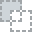
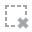
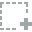
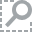
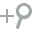
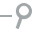
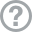
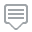
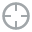
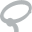
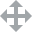
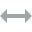
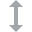
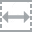
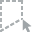
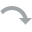
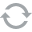
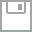
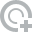
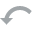
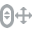
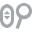
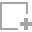
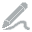
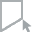
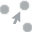
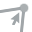
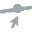

In [23]:
df_ramadan = get_ramadan(df_cleaned).reset_index(drop=True)
df_ramadan["hypo"] = df_ramadan["hypo"].astype(int)
if "Ramadan" in df_ramadan:
    del df_ramadan["Ramadan"]

create_report(df_ramadan)

# Before Vs During Ramadan

In [24]:
def boxplot_distribution(df, main_col="CGM", operator="mean", pid_col="patientID",
                         time_col="time", remove_zero_steps=True):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0].copy()
    else:
        df_tmp = df.copy()

    # Get day correlation
    df_tmp["Date"] = df_tmp[time_col].dt.date
    df_tmp = df_tmp.groupby([pid_col, "Date"])[main_col].agg(operator).reset_index()
    
    sns.set_theme(style="ticks")
    
    # Plot the orbital period with horizontal boxes
    df_tmp["Ramadan"] = df_tmp["Date"].apply(lambda x: ramadan_flag(x))

    g = sns.boxplot(x=pid_col, y=main_col, hue="Ramadan", data=df_tmp)
    sns.stripplot(x=pid_col, y=main_col, data=df_tmp,
                  size=4, color=".3", linewidth=0)
    
    #g.set(ylabel='Pearson Correlation\n%s-%s' % (main_col, secondary_col))
    
    sns.despine(offset=10, trim=True)
    
    # Move the legend to the right side
    g.legend(title="Ramadan?", bbox_to_anchor=(1.3, 0.5), ncol=1)
    
    return g


In [25]:
# TODO:
# Percentage difference before vs during ramadan
# Check it out if periods of day have differences ()
# Pulse rate is lower if they are fasting or just doing less PA
# Delayed correlation rate (PA correated with delayed CGM X hours ahead)
# Missing PIDs

<AxesSubplot:xlabel='patientID', ylabel='HeartRate'>

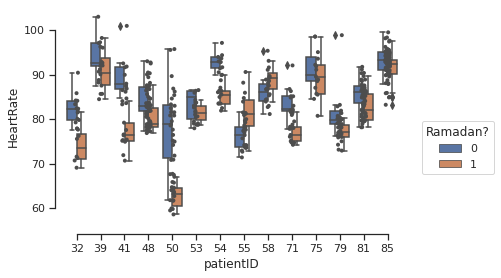

In [26]:
boxplot_distribution(df_cleaned, "HeartRate", operator="mean", remove_zero_steps=False)

<AxesSubplot:xlabel='patientID', ylabel='Calories'>

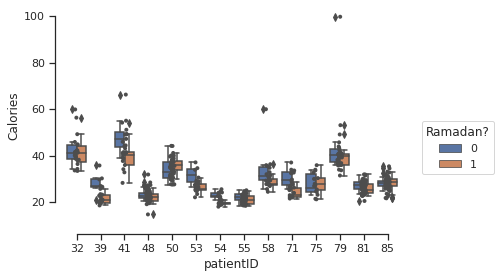

In [27]:
boxplot_distribution(df_cleaned, "Calories", operator="mean", remove_zero_steps=False)

<AxesSubplot:xlabel='patientID', ylabel='mets'>

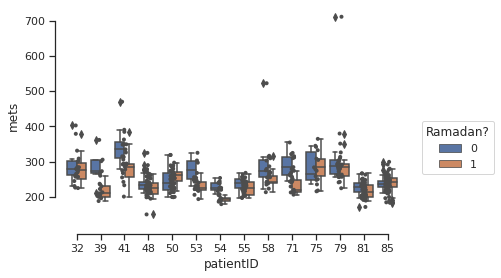

In [28]:
boxplot_distribution(df_cleaned, "mets", operator="mean", remove_zero_steps=False)

<AxesSubplot:xlabel='patientID', ylabel='Steps'>

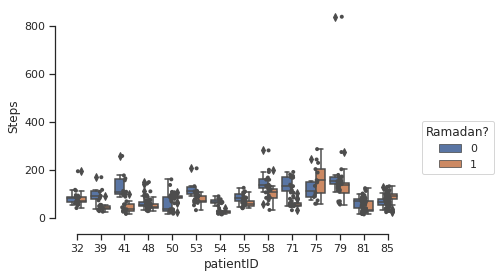

In [29]:
boxplot_distribution(df_cleaned, "Steps", operator="mean", remove_zero_steps=False)

<AxesSubplot:xlabel='patientID', ylabel='CGM'>

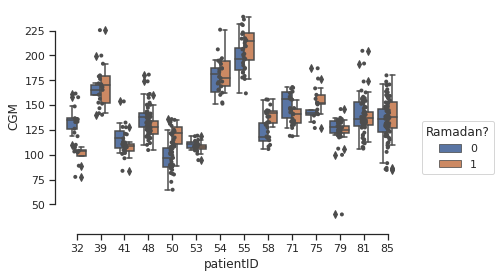

In [30]:
boxplot_distribution(df_cleaned, "CGM", operator="mean", remove_zero_steps=False)

## Correlation Analysis

### Correlations at day-level for each user

Answering questions like: In a given day, how do the CGM and Number of Steps correlate for a given user?

In [31]:
def boxplot_delayed_correlation_with_filter(df, secondary_col, main_col="CGM",
                                            pid_col="patientID", time_col="time", time_delay="0h15t",
                                            remove_zero_steps=True, 
                                            # Optional data
                                            agg_operator="mean", main_min_filter=0, secondary_min_filter=0):

    if remove_zero_steps:
        df_tmp = df[df["Steps"] > 0].copy()
    else:
        df_tmp = df.copy()

    shifted_col_name = "Shifted_" + time_delay + "_" + secondary_col
        
    # Group data by patient, select a column and shift dataset 
    df_shifted = df_tmp.set_index(time_col).groupby(pid_col)[[secondary_col]].shift(freq=time_delay).reset_index()
    df_shifted = df_shifted.rename(columns={secondary_col: shifted_col_name})
    # Merge back the shifted dataset
    df_tmp = pd.merge(df_tmp, df_shifted, on=["patientID", "time"])
    
    # Get day correlation and apply operator
    df_tmp["Date"] = df_tmp[time_col].dt.date
    
    df_corr = df_tmp.groupby([pid_col, "Date"])[[main_col, shifted_col_name]].corr().reset_index()
    df_corr = df_corr[df_corr["level_2"] == main_col]
    
    df_mean = df_tmp.groupby([pid_col, "Date"])[[main_col, shifted_col_name]].agg(agg_operator).reset_index()
    
    # merge temporary dataframes
    df_tmp = pd.merge(df_corr, df_mean, on=[pid_col, "Date"], suffixes=("", "_" + agg_operator))
    
    # optionally filters rows that are below the minimal defined by `main_min_filter` and `secondary_min_filter`
    df_tmp = df_tmp[df_tmp[main_col + "_" + agg_operator] >= main_min_filter]
    df_tmp = df_tmp[df_tmp[shifted_col_name + "_" + agg_operator] >= secondary_min_filter]
    
    # After all data modifications, we add the Ramadan flag
    df_tmp["Ramadan"] = df_tmp["Date"].apply(lambda x: ramadan_flag(x))
    
    # Plot the results    
    sns.set_theme(style="ticks")
    
    # Plot the orbital period with horizontal boxes
    g = sns.boxplot(x=pid_col, y=shifted_col_name, hue="Ramadan", data=df_tmp)
    sns.stripplot(x=pid_col, y=shifted_col_name, data=df_tmp,
                  size=4, color=".3", linewidth=0)
    
    g.set(ylabel='Pearson Correlation\n%s-%s' % (main_col, shifted_col_name))
    
    sns.despine(offset=10, trim=True)
    
    # Move the legend to the right side
    g.legend(title="Ramadan?", bbox_to_anchor=(1.3, 0.5), ncol=1)
    
    # Remove useless cols that were added by the correlation operator
    del df_tmp["level_2"]
    del df_tmp[main_col]
    
    return df_tmp, g
    


In [32]:
# correlations = {}

# for time_delay in ["0h00t", "1h00t", "2h00t", "3h00t", "4h00t", "5h00t", "6h00t", "7h00t", "8h00t"]:
#     c, g = boxplot_delayed_correlation(df_cleaned, "mets", remove_zero_steps=False, time_delay=time_delay)
#     correlations[time_delay] = c


(     patientID        Date  Shifted_4h00t_CGM    CGM_mean  \
 0           32  2020-02-17          -0.203091  179.933334   
 1           32  2020-02-19          -0.322881  141.937500   
 2           32  2020-02-20          -0.139837  133.563828   
 3           32  2020-02-21          -0.074016  139.511902   
 4           32  2020-02-22          -0.473253  135.296875   
 ..         ...         ...                ...         ...   
 470         85  2020-05-19          -0.036315  136.000000   
 471         85  2020-05-20          -0.094763  156.693176   
 472         85  2020-05-21           0.043918  160.438782   
 473         85  2020-05-22          -0.345245  180.807693   
 474         85  2020-05-23           0.167032  160.553925   
 
      Shifted_4h00t_CGM_mean  Ramadan  
 0                145.366669        0  
 1                139.037506        0  
 2                128.414886        0  
 3                139.214279        0  
 4                133.984375        0  
 ..           

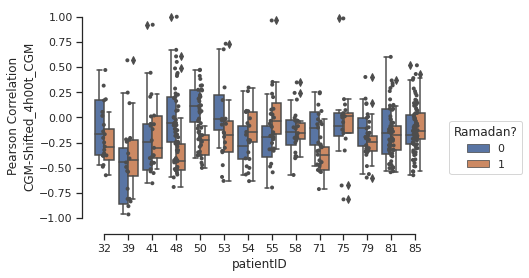

In [33]:
boxplot_delayed_correlation_with_filter(df_cleaned, main_col="CGM", secondary_col="CGM",
                                        remove_zero_steps=False, time_delay="4h00t", 
                                        agg_operator="mean", main_min_filter=0, secondary_min_filter=0)

In [34]:
df_cleaned["mets"].describe()

count    37023.000000
mean       245.500635
std        146.270944
min        150.000000
25%        156.000000
50%        195.000000
75%        274.000000
max       1984.000000
Name: mets, dtype: float64

(     patientID        Date  Shifted_5h00t_mets    CGM_mean  \
 0           32  2020-02-17            0.367883  184.083328   
 1           32  2020-02-19           -0.307072  145.657898   
 2           32  2020-02-20            0.206324  133.574463   
 3           32  2020-02-21            0.148727  139.857147   
 4           32  2020-02-22            0.068423  135.296875   
 ..         ...         ...                 ...         ...   
 467         85  2020-05-19           -0.449681  131.866669   
 468         85  2020-05-20           -0.523524  160.350006   
 469         85  2020-05-21           -0.580476  158.266663   
 470         85  2020-05-22            0.094076  179.056458   
 471         85  2020-05-23           -0.310988  156.009659   
 
      Shifted_5h00t_mets_mean  Ramadan  
 0                 372.833333        0  
 1                 269.342105        0  
 2                 273.404255        0  
 3                 265.714286        0  
 4                 240.515625        

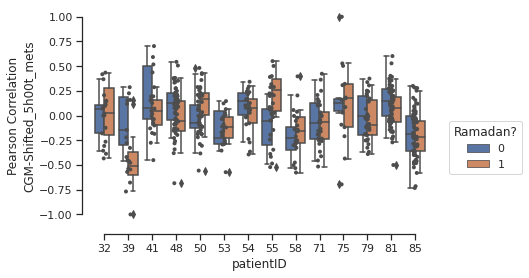

In [35]:
boxplot_delayed_correlation_with_filter(df_cleaned, "mets", remove_zero_steps=False, time_delay="5h00t")

In [ ]:
boxplot_correlation(df_cleaned, "Steps")

In [ ]:
boxplot_correlation(df_cleaned, "Calories")

In [ ]:
boxplot_correlation(df_cleaned, "HeartRate")

### Correlations at user level

Next, our aim is to create correlation at user level. For that, we first aggregate the data at day level (e.g., average number of steps in a day) and then average the data at user level (i.e., average number of steps per day for participant X).

For that, we will first load the EMR data and do a few data cleaning steps.

#### Load EMR data, clean and pivot it

In [66]:
df_emr = read_data(SihaEmrDataset, {SihaEmrDataset: "value"})
df_emr = df_emr.pivot(index="patientID", columns="variable", values="value")

emr_cols = ['BMI', 'Cholesterol', 'Creatinine', 'Diabetes Duration',
            'Diastolic Blood Pressure', 'HDL', 'HbA1c', 'LDL', 'Systolic Blood Pressure']

# For some reason this was understood as a string col and we need to replace empty string to NAN manually
df_emr["Diabetes Duration"] = df_emr["Diabetes Duration"].replace('', np.nan)

for emr_col in emr_cols:
    print(emr_col)
    df_emr[emr_col] = df_emr[emr_col].astype(np.float)

df_emr.head()
# TODO: get pids of missing EMR data

BMI
Cholesterol
Creatinine
Diabetes Duration
Diastolic Blood Pressure
HDL
HbA1c
LDL
Systolic Blood Pressure


variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
27         28.9          5.1        79.0                6.0   
30         37.8          6.4        65.0               10.0   
31         26.0          3.2        81.0               17.0   
32         33.0          NaN         NaN               11.0   
34         28.7          3.0        96.0                2.0   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
27                             75.0  1.0    8.1  3.1                    121.0   
30                             86.0  1.1    7.8  4.5                    135.0   
31                             96.0  0.9    9.6  1.5                    134.0   
32                             77.0  NaN    7.8  NaN                    142.0   
34                             78.0  0.8   10.0  1.5                    146.0   

variable  Triglyceride  
patientID               
27                   2  
30                 1.7  
31                 1.6  
32                 NaN  
34                 1.5

In [67]:
# Missing data listed below:
df_emr[df_emr.isnull().any(axis=1)]

variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
32         33.0          NaN         NaN               11.0   
48         30.3          NaN         NaN               11.0   
49         38.1          NaN        62.0               14.0   
55         26.0          4.0        37.0                NaN   
65         24.0          NaN         NaN                4.0   
67         32.0          NaN         NaN               26.0   
70         24.8          NaN         NaN               10.0   
71         23.7          3.1        85.0               10.0   
74         28.7          NaN         NaN               30.0   

variable                                 Diabetes Medication  \
patientID                                                      
32                      Dapagliflozin, Sitagliptin+Metformin   
48           Glargine, Metformin, Empagliflozin, Sitagliptin   
49         Dapagliflozin, Sitagliptin+Metformin, Glargine...   
55                      Glargine 300, Metformin, Liraglutide   
65         Sitagliptin+Metformin, Dapagliflozin, Glargine...   
67                  Glargine 300, Sitagliptin, Dapagliflozin   
70         Sitagliptin+Metformin, Dapagliflozin, Glargine...   
71         Vildagliptin+, Metformin, Dapagliflozin, Piogl...   
74         Glargine 300, Pioglitazone, Metformin, Liraglu...   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
32                             77.0  NaN    7.8  NaN                    142.0   
48                             90.0  NaN    7.0  NaN                    143.0   
49                             79.0  NaN   13.8  NaN                    142.0   
55                             53.0  1.0    8.0  2.5                    117.0   
65                             79.0  NaN    NaN  NaN                    116.0   
67                             68.0  NaN    9.8  NaN                    114.0   
70                              NaN  NaN    NaN  NaN                      NaN   
71                              NaN  1.3    7.8  1.3                      NaN   
74                             60.0  NaN    NaN  NaN                    111.0   

variable  Triglyceride  
patientID               
32                 NaN  
48                 NaN  
49                 NaN  
55                 1.2  
65                 NaN  
67                 NaN  
70                 NaN  
71                   1  
74                 NaN

In [68]:
has_any_missing_emr = df_emr[df_emr.isnull().any(axis=1)].index
set(df_cleaned["patientID"].unique()) & set(has_any_missing_emr) 

{32, 48, 55, 71}

In [69]:
# Tried to normalize the drug names
drugs = set([])
for tmp in df_emr["Diabetes Medication"]:
    for d in tmp.replace("+", ", ").split(","):
        if d.strip():
            # This should get rid of the dosage (Glargine 300 or Glargine 100 -> Glargine)
            d = d.split()[0].strip()
            drugs.add(d)


print("%d different drugs: %s" % (len(drugs), drugs))

for d in drugs:
    df_emr[d] = df_emr["Diabetes Medication"].apply(lambda x: d in x)

df_emr.head()

14 different drugs: {'Glicalzide', 'Degludec', 'Metformin', 'Exenatide', 'Dapagliflozin', 'Dulaglutide', 'Aspart', 'Sitagliptin', 'Liraglutide', 'Pioglitazone', 'Glargine', 'Glimepride', 'Vildagliptin', 'Empagliflozin'}


variable    BMI  Cholesterol  Creatinine  Diabetes Duration  \
patientID                                                     
27         28.9          5.1        79.0                6.0   
30         37.8          6.4        65.0               10.0   
31         26.0          3.2        81.0               17.0   
32         33.0          NaN         NaN               11.0   
34         28.7          3.0        96.0                2.0   

variable                                 Diabetes Medication  \
patientID                                                      
27                    Sitagliptin, Glicalzide, Empagliflozin   
30         Metformin, Dapagliflozin, Sitagliptin, Pioglit...   
31         Glargine 300, Sitagliptin, Pioglitazone, Vilda...   
32                      Dapagliflozin, Sitagliptin+Metformin   
34                                Sitagliptin, Empagliflozin   

variable   Diastolic Blood Pressure  HDL  HbA1c  LDL  Systolic Blood Pressure  \
patientID                                                                       
27                             75.0  1.0    8.1  3.1                    121.0   
30                             86.0  1.1    7.8  4.5                    135.0   
31                             96.0  0.9    9.6  1.5                    134.0   
32                             77.0  NaN    7.8  NaN                    142.0   
34                             78.0  0.8   10.0  1.5                    146.0   

variable  Triglyceride  Glicalzide  Degludec  Metformin  Exenatide  \
patientID                                                            
27                   2        True     False      False      False   
30                 1.7       False     False       True      False   
31                 1.6       False     False       True      False   
32                 NaN       False     False       True      False   
34                 1.5       False     False      False      False   

variable   Dapagliflozin  Dulaglutide  Aspart  Sitagliptin  Liraglutide  \
patientID                                                                 
27                 False        False   False         True        False   
30                  True        False    True         True        False   
31                 False        False   False         True        False   
32                  True        False   False         True        False   
34                 False        False   False         True        False   

variable   Pioglitazone  Glargine  Glimepride  Vildagliptin  Empagliflozin  
patientID                                                                   
27                False     False       False         False           True  
30                 True      True       False         False          False  
31                 True      True       False          True          False  
32                False     False       False         False          False  
34                False     False       False         False           True

In [70]:
df_agg = pd.concat([mean_per_day(df_cleaned, "Steps", "MeanSteps", remove_zero_steps=True),
                      sum_per_day(df_cleaned, "Steps", "SumSteps", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "Calories", "MeanCalories", remove_zero_steps=True),
                      sum_per_day(df_cleaned, "Calories", "SumCalories", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "Distance", "MeanDistance", remove_zero_steps=True),
                      sum_per_day(df_cleaned, "Distance", "SumDistance", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "mets", "MeanMETS", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "HeartRate", "MeanHeartRate", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "CGM", "MeanCGM", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "hypo", "Mean#Hypo", remove_zero_steps=True),
                      sum_per_day(df_cleaned, "hypo", "TotalHypo", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "hyper", "Mean#Hyper", remove_zero_steps=True),
                      sum_per_day(df_cleaned, "hyper", "TotalHyper", remove_zero_steps=True),
                      mean_per_day(df_cleaned, "Ramadan", "IsRamadan", remove_zero_steps=True),
                      ], axis=1).reset_index()
df_means = df_agg.groupby("patientID").mean()
df_means.head()

MeanSteps     SumSteps  MeanCalories  SumCalories  MeanDistance  \
patientID                                                                     
32         121.105591  6025.333496     50.556847  2539.665771      0.059519   
39          97.832428  3463.736816     28.477617   980.619995      0.041499   
41         122.701607  4045.250000     53.818687  1906.372559      0.058185   
48         100.830505  4140.887207     27.874519  1152.474976      0.032886   
50         132.719299  5808.155762     45.185219  1956.943115      0.061840   

           SumDistance    MeanMETS  MeanHeartRate     MeanCGM  Mean#Hypo  \
patientID                                                                  
32            2.961275  340.060849      84.007599  125.269157   0.016807   
39            1.469370  287.885337      98.240784  176.231445   0.000000   
41            1.917922  381.774038      87.760277  113.726624   0.016226   
48            1.350531  283.883487      86.630280  135.871185   0.001315   
50            2.706337  326.035208      78.442734  104.788094   0.147368   

           TotalHypo  Mean#Hyper  TotalHyper  IsRamadan  
patientID                                                
32          0.809524    0.067380    3.333333   0.380952  
39          0.000000    0.481490   15.052632   0.631579  
41          0.458333    0.010101    0.333333   0.541667  
48          0.064516    0.099966    4.451613   0.354839  
50          6.400000    0.033342    1.488889   0.311111

In [71]:
df_merged = pd.merge(df_means, df_emr, left_index=True, right_index=True)
df_merged.head()

MeanSteps     SumSteps  MeanCalories  SumCalories  MeanDistance  \
patientID                                                                     
32         121.105591  6025.333496     50.556847  2539.665771      0.059519   
39          97.832428  3463.736816     28.477617   980.619995      0.041499   
48         100.830505  4140.887207     27.874519  1152.474976      0.032886   
50         132.719299  5808.155762     45.185219  1956.943115      0.061840   
53         159.439255  6482.600098     35.390106  1410.535645      0.069389   

           SumDistance    MeanMETS  MeanHeartRate     MeanCGM  Mean#Hypo  \
patientID                                                                  
32            2.961275  340.060849      84.007599  125.269157   0.016807   
39            1.469370  287.885337      98.240784  176.231445   0.000000   
48            1.350531  283.883487      86.630280  135.871185   0.001315   
50            2.706337  326.035208      78.442734  104.788094   0.147368   
53            2.821783  309.895863      86.437775  108.562859   0.004402   

           TotalHypo  Mean#Hyper  TotalHyper  IsRamadan   BMI  Cholesterol  \
patientID                                                                    
32          0.809524    0.067380    3.333333   0.380952  33.0          NaN   
39          0.000000    0.481490   15.052632   0.631579  22.0          2.5   
48          0.064516    0.099966    4.451613   0.354839  30.3          NaN   
50          6.400000    0.033342    1.488889   0.311111  33.8          5.5   
53          0.200000    0.003239    0.150000   0.700000  29.0          3.2   

           Creatinine  Diabetes Duration  \
patientID                                  
32                NaN               11.0   
39               84.0               12.0   
48                NaN               11.0   
50               91.0               23.0   
53               69.0               12.0   

                                         Diabetes Medication  \
patientID                                                      
32                      Dapagliflozin, Sitagliptin+Metformin   
39         Sitagliptin, Pioglitazone, Vildagliptin+, Metf...   
48           Glargine, Metformin, Empagliflozin, Sitagliptin   
50                         Sitagliptin+Metformin, Glimepride   
53         Dapagliflozin, Sitagliptin+Metformin, Pioglita...   

           Diastolic Blood Pressure  HDL  HbA1c   LDL  \
patientID                                               
32                             77.0  NaN    7.8   NaN   
39                             77.0  0.8    9.3  0.94   
48                             90.0  NaN    7.0   NaN   
50                             64.0  1.2    6.1  3.60   
53                             91.0  1.0    6.0  1.80   

           Systolic Blood Pressure Triglyceride  Glicalzide  Degludec  \
patientID                                                               
32                           142.0          NaN       False     False   
39                           113.0          1.7       False     False   
48                           143.0          NaN       False     False   
50                           104.0          1.4       False     False   
53                           149.0          0.7       False     False   

           Metformin  Exenatide  Dapagliflozin  Dulaglutide  Aspart  \
patientID                                                             
32              True      False           True        False   False   
39              True      False          False        False   False   
48              True      False          False        False   False   
50              True      False          False        False   False   
53              True      False           True        False   False   

           Sitagliptin  Liraglutide  Pioglitazone  Glargine  Glimepride  \
patientID                                                                 
32                True        False         False     False 

In [72]:
print("Missing participants: ", set(df_means.index) - set(df_emr.index))

Missing participants:  {41, 85}


In [73]:
total_participants = df_merged.shape[0]
print("Total number of participants at this analysis: %d" % (total_participants))
for d in drugs:
    df_drug = df_merged[df_merged[d] == True]
    print("Participants in the final dataset that took drug %s: %d (%.2f%%)" % (d, df_drug.shape[0], 100.*df_drug.shape[0]/total_participants))

Total number of participants at this analysis: 12
Participants in the final dataset that took drug Glicalzide: 1 (8.33%)
Participants in the final dataset that took drug Degludec: 2 (16.67%)
Participants in the final dataset that took drug Metformin: 12 (100.00%)
Participants in the final dataset that took drug Exenatide: 0 (0.00%)
Participants in the final dataset that took drug Dapagliflozin: 5 (41.67%)
Participants in the final dataset that took drug Dulaglutide: 1 (8.33%)
Participants in the final dataset that took drug Aspart: 1 (8.33%)
Participants in the final dataset that took drug Sitagliptin: 8 (66.67%)
Participants in the final dataset that took drug Liraglutide: 2 (16.67%)
Participants in the final dataset that took drug Pioglitazone: 4 (33.33%)
Participants in the final dataset that took drug Glargine: 4 (33.33%)
Participants in the final dataset that took drug Glimepride: 1 (8.33%)
Participants in the final dataset that took drug Vildagliptin: 3 (25.00%)
Participants in t

In [74]:
class1 = 'Metformin'
class2 =  'Glicalzide', 'Glimepride'
class3 = ddp4 = 'Vildagliptin', 'Sitagliptin'
class4 = 'Dapagliflozin', 'Empagliflozin'
class5 = 'Liraglutide', 'Exenatide'
class6 = 'Glargine', 'Degludec'
class7 = 'Aspart'
class8 = 'Pioglitazone'

We are now able to compare the correlation between any number of groups.
For example, below we verify that the correlation between average CGM and HeartRate was strong for participants taking the combo of Metformin and Sitagliptin, while it was the opposite for participants not taking these drugs. 

⭐️⭐️⭐️ <b> TODO: we need to know what kind of medicament combination is important! </b> ⭐️⭐️⭐️

In [75]:
# Compared the data for the 8 participants that took Sitagliptin against the 4 ones that did not take it
df_grp1 = df_merged[(df_merged['Liraglutide'] == True)]
df_grp2 = df_merged[~((df_merged['Liraglutide'] == True))]

print("Corr CGM-HeartRate Grp1: %.3f, Grp2: %.3f" % (df_grp1.corr()["MeanCGM"]["MeanHeartRate"],
                                                     df_grp2.corr()["MeanCGM"]["MeanHeartRate"]))

Corr CGM-HeartRate Grp1: -1.000, Grp2: 0.861


Before moving to the next section, we save a postprocessed dataframe to disk in order to speed up futher ML pipelines.

In [76]:
profast_ml = os.path.join(profast_datapath, "preprocessed")
if not os.path.exists(profast_ml):
    os.mkdir(profast_ml)

df_cleaned.to_csv(os.path.join(profast_ml, "df_cleaned.csv.gz"), index=False)
df_emr.to_csv(os.path.join(profast_ml, "df_cleaned_emr.csv.gz"))

<a id='machine_learning'></a>
## 2 - Machine Learning for CGM Prediction

--- This is a work in progress ---

This second part of this notebook used the preprocessed data from profast 2020 for CGM prediction.
Note that we can move this section elsewhere without problem if this notebook becomes too extense.
For that, we start by loading the preprocessed data.

In [3]:
from sklearn.model_selection import LeaveOneGroupOut, KFold, GroupKFold

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_relevant_features
#from pycaret.regression import *
from pycaret.classification import *

init


In [4]:
profast_ml = os.path.join(profast_datapath, "preprocessed")

df = pd.read_csv(os.path.join(profast_ml, "df_cleaned.csv.gz"))

df["time"] = pd.to_datetime(df["time"])
df.head()

patientID                time  HeartRate  level   mets  Calories  Steps  \
0         32 2020-02-17 10:30:00  88.266670    1.0  616.0  91.58072  408.0   
1         32 2020-02-17 10:45:00  75.933334    1.0  234.0  34.78878   22.0   
2         32 2020-02-17 11:00:00  75.066666    1.0  440.0  65.41480  309.0   
3         32 2020-02-17 11:15:00  76.600000    1.0  282.0  41.92494  106.0   
4         32 2020-02-17 11:30:00  83.466670    1.0  339.0  50.39913  170.0   

   Distance    CGM  Ramadan  hypo  shypo  hyper  
0  0.200765  128.0        0     0      0      0  
1  0.010750  128.5        0     0      0      0  
2  0.151863  171.0        0     0      0      0  
3  0.052071  176.0        0     0      0      0  
4  0.083574  172.0        0     0      0      0

In [5]:
df_emr = pd.read_csv(os.path.join(profast_ml, "df_cleaned_emr.csv.gz"))

Next, following the idea of [this tensorflow tutorial on time_series analysis](https://www.tensorflow.org/tutorials/structured_data/time_series), we transformed time of the day into a continous sin/cos cyclic feature.

<AxesSubplot:>

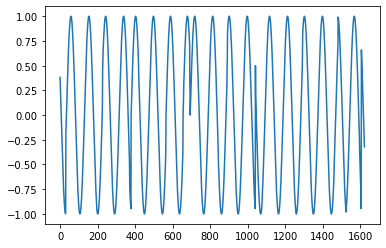

In [6]:
def convert_time_sin_cos(df, datetime_col):

    if datetime_col not in df:
        print("ERROR datetime_col %s not in df!" % (datetime_col))
        return
    
    if not pd.api.types.is_datetime64_ns_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    sec_in_day = 24*60*60
    
    ts = df[datetime_col].apply(lambda x: x.timestamp()).astype(int)
    day_sin = np.sin(ts * (2 * np.pi / sec_in_day))
    day_cos = np.cos(ts * (2 * np.pi / sec_in_day))
    
    return day_sin, day_cos
    
    
df["time_sin"], df["time_cos"] = convert_time_sin_cos(df, "time")

df[df["patientID"] == 32]["time_sin"].plot()


In [7]:
def generate_slide_wins(df_in, start_seq=0, winsize="1h00t", delta="0h15t", 
                        time_col="time", 
                        label_col="CGM", pid_col="patientID"):
    """
    From a timeseries of ONE participant, this function generates two dataframes: <time_series_features>, <labels>
    The first dataframe can be used with tsfresh later on, while the second has all the labels that we want to predict.

    Notice that the default winsize is 1h and 15 minutres (`1h15t`).
    We used the first hour to extract the features and the 15 min only to collect the ground_truth labels.

    """
    seq_id = start_seq
    transformed_df = []
    list_of_indices = []
    labels = []
    label_times = []

    pid = df_in[pid_col].unique()
    if len(pid) > 1:
        print("ERROR: We should have only one pid here. Aborting")
        return
    pid = pid[0]
    
    df = df_in.reset_index(drop=True).copy()
    
    # The following code will construct a rolling win that could be based on either time or #win
    # This will feed list_of_indexes with the sub-win indices that will be used in the next for loop
    df.reset_index().rolling(winsize, on=time_col, center=False, closed="both")["index"].apply((lambda x: list_of_indices.append(x.tolist()) or 0))

    # Time-based win might be smaller than the expected size. 
    expected_size = (winsize // pd.Timedelta("15t")) + 1

    # Save a time indexed copy of the dataframe
    dftime = df.set_index(time_col).copy()
    
    for idx in list_of_indices:
        if len(idx) != expected_size:
            continue
            
        last_row = df.loc[idx].iloc[-1]
        label_time = last_row[time_col] + pd.Timedelta(delta)
        
        if label_time not in dftime.index:
            continue
        
        label = dftime.loc[label_time][label_col]
        
        # save instance
        labels.append(label)
        label_times.append(label_time)
        
        tmp_df = df.loc[idx].copy()
        tmp_df["seq_id"] = seq_id
        seq_id += 1

        del tmp_df[pid_col]
        
        transformed_df.append(tmp_df)

    labels = pd.Series(labels)
    labels.name = "ground_truth"
    
    label_times = pd.Series(label_times)
    label_times.name = "gt_time"
    
    transformed_df = pd.concat(transformed_df).reset_index(drop=True)
    pid = pd.Series([pid] * labels.shape[0])
    pid.name = "pid"
    
    return seq_id, transformed_df, labels, label_times, pid


def generate_timeseries_df(df, signals, winsize, delta, pid_col="patientID"):

    df_labels = []
    df_label_times = []
    df_timeseries = []
    df_pids = []

    last_seq_id = 0

    for pid in tqdm(df[pid_col].unique()):

        df_tmp = df[df[pid_col] == pid]

        last_seq_id, df_ts, df_label, df_label_time, df_pid = generate_slide_wins(df_tmp[signals],
                                                                                  start_seq=last_seq_id,
                                                                                  winsize=winsize,
                                                                                  delta=delta)
        df_timeseries.append(df_ts)
        df_labels.append(df_label)
        df_label_times.append(df_label_time)
        df_pids.append(df_pid)

    df_labels = pd.concat(df_labels).reset_index(drop=True)
    df_label_times = pd.concat(df_label_times).reset_index(drop=True)
    df_timeseries = pd.concat(df_timeseries).reset_index(drop=True)

    df_pids = pd.concat(df_pids).reset_index(drop=True)
    df_pids.name = "pid"
    
    return df_timeseries, df_labels, df_label_times, df_pids

In [8]:
# Example of how to use it
generate_slide_wins(df.head(30), start_seq=0, winsize="3h00t", delta="2h")

(10,
                    time  HeartRate  level   mets  Calories  Steps  Distance  \
 0   2020-02-17 10:30:00  88.266670    1.0  616.0  91.58072  408.0  0.200765   
 1   2020-02-17 10:45:00  75.933334    1.0  234.0  34.78878   22.0  0.010750   
 2   2020-02-17 11:00:00  75.066666    1.0  440.0  65.41480  309.0  0.151863   
 3   2020-02-17 11:15:00  76.600000    1.0  282.0  41.92494  106.0  0.052071   
 4   2020-02-17 11:30:00  83.466670    1.0  339.0  50.39913  170.0  0.083574   
 5   2020-02-17 11:45:00  84.733330    1.0  458.0  68.09086  424.0  0.208656   
 6   2020-02-17 12:00:00  91.466670    0.0  216.0  32.11272    0.0  0.000000   
 7   2020-02-17 12:15:00  97.066666    1.0  422.0  62.73874  112.0  0.055116   
 8   2020-02-17 12:30:00  90.866670    1.0  446.0  66.30682  138.0  0.067792   
 9   2020-02-17 12:45:00  90.266670    1.0  445.0  66.15815  161.0  0.078976   
 10  2020-02-17 13:00:00  85.533330    1.0  324.0  48.16908   87.0  0.042688   
 11  2020-02-17 13:15:00  92.400000

In [9]:
def generate_slide_wins_from_block(df_in, start_seq=0, winsize="1h00t",
                                   delta="0h00t", win_of_interest="2h00t",
                                   time_col="time", 
                                   label_cols=["hyper", "hypo"], pid_col="patientID"):
    """
    From a timeseries of ONE participant, this function generates two dataframes: <time_series_features>, <labels>
    The first dataframe can be used with tsfresh later on, while the second has all the labels that we want to predict.

    Notice that the default winsize is 1h and 15 minutres (`1h15t`).
    We used the first hour to extract the features and the 15 min only to collect the ground_truth labels.

    """
    seq_id = start_seq
    transformed_df = []
    list_of_indices = []
    labels = []
    label_times = []

    pid = df_in[pid_col].unique()
    if len(pid) > 1:
        print("ERROR: We should have only one pid here. Aborting")
        return
    pid = pid[0]
    
    df = df_in.reset_index(drop=True).copy()
    
    # The following code will construct a rolling win that could be based on either time or #win
    # This will feed list_of_indexes with the sub-win indices that will be used in the next for loop
    df.reset_index().rolling(winsize, on=time_col, center=False, closed="both")["index"].apply((lambda x: list_of_indices.append(x.tolist()) or 0))

    # Time-based win might be smaller than the expected size. 
    expected_size = (winsize // pd.Timedelta("15t")) + 1

    # Save a time indexed copy of the dataframe
    dftime = df.set_index(time_col).copy()
    
    # We need to shift the data first and then roll and sum each part
    # This operation will give us the sum of the label in the window of size `win_of_interest` from a given timestapm
    
    labels_of_interest = []
    for label_col in label_cols:
        label_of_interest = label_col + "_" + win_of_interest
        dftime[label_of_interest] = dftime[label_col].shift(freq="-%s" % (win_of_interest))
        dftime[label_of_interest] = dftime[label_of_interest].fillna(0.0).rolling(win_of_interest, center=False, closed="both").sum(skipna=True)
        labels_of_interest.append(label_of_interest)

    for idx in list_of_indices:
        if len(idx) != expected_size:
            continue
            
        last_row = df.loc[idx].iloc[-1]
        label_time = last_row[time_col] + pd.Timedelta(delta)
        
        if label_time not in dftime.index:
            continue
        
        label = dftime.loc[label_time][labels_of_interest].values
        
        # save instance
        labels.append(label)
        label_times.append(label_time)
        
        tmp_df = df.loc[idx].copy()
        tmp_df["seq_id"] = seq_id
        seq_id += 1

        del tmp_df[pid_col]
        
        transformed_df.append(tmp_df)

    labels = pd.DataFrame(labels, columns=label_cols)
    labels.name = "ground_truth"
    
    label_times = pd.Series(label_times)
    label_times.name = "gt_time"
    
    transformed_df = pd.concat(transformed_df).reset_index(drop=True)
    pid = pd.Series([pid] * labels.shape[0])
    pid.name = "pid"
    
    return seq_id, transformed_df, labels, label_times, pid


def generate_timeseries_df_from_block(df, signals, winsize, delta, win_of_interest, pid_col="patientID",
                                      label_cols=["hyper", "hypo"]):

    df_labels = []
    df_label_times = []
    df_timeseries = []
    df_pids = []

    last_seq_id = 0

    for pid in tqdm(df[pid_col].unique()):

        df_tmp = df[df[pid_col] == pid]

        last_seq_id, df_ts, df_label, df_label_time, df_pid = generate_slide_wins_from_block(df_tmp[signals],
                                                                                             label_cols=label_cols,
                                                                                             start_seq=last_seq_id,
                                                                                             winsize=winsize,
                                                                                             delta=delta,
                                                                                             win_of_interest=win_of_interest)
        df_timeseries.append(df_ts)
        df_labels.append(df_label)
        df_label_times.append(df_label_time)
        df_pids.append(df_pid)

    df_labels = pd.concat(df_labels).reset_index(drop=True)
    df_label_times = pd.concat(df_label_times).reset_index(drop=True)
    df_timeseries = pd.concat(df_timeseries).reset_index(drop=True)

    df_pids = pd.concat(df_pids).reset_index(drop=True)
    df_pids.name = "pid"
    
    return df_timeseries, df_labels, df_label_times, df_pids

Different winsizes will render different number of epochs. 
For example, if we do not have continous CGM recorded for 5 hours, we cannot generate features with a winsize bigger than 4:45min.


In [46]:
def extract_features_from_df(df_timeseries, df_labels, winsize, delta, win_of_interest="0h"):
    
    output_filename = os.path.join(profast_ml, "filtered_features_%s_d%s_wi_%s.csv.gz" % (winsize, delta, win_of_interest))
    
    if os.path.exists(output_filename):
        features_filtered = pd.read_csv(output_filename)
    else:
        features_filtered = extract_relevant_features(df_timeseries, df_labels, column_id='seq_id', column_sort='time')
        features_filtered.to_csv(output_filename, index=False)
    
    return features_filtered

def get_filename(winsize, delta, win_of_interest):
    if win_of_interest == "0h":
        filename = os.path.join(profast_ml, "data_%s_d%s.csv.gz" % (winsize, delta))
    else:
        filename = os.path.join(profast_ml, "data_%s_d%s_wi_%s.csv.gz" % (winsize, delta, win_of_interest))
    return filename

def save_data(df, winsize, delta, win_of_interest="0h"):
    output_filename = os.path.join(profast_ml, "data_%s_d%s_wi_%s.csv.gz" % (winsize, delta, win_of_interest))
    df.to_csv(output_filename, index=False)
    
def load_data(winsize, delta, win_of_interest="0h"):
    filename = get_filename(winsize, delta, win_of_interest)
    return pd.read_csv(filename)

def data_exists(winsize, delta, win_of_interest="0h"):
    filename = get_filename(winsize, delta, win_of_interest)
    print("Filename:", filename)
    return os.path.exists(filename)

def add_weekend(df, time_col):
    df["time_weekend"] = df[time_col].dt.weekday.isin([4,5]) # Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.    


In [50]:
signals = ["time", "patientID", "HeartRate", "mets", "Calories", "Steps", "Distance", "CGM"]

# Add to this code a check to see if saved data is already there. 

winsizes = ["5h", "3h", "4h"]
deltas = ["0h"]
wins_of_interest = ["5h", "1h", "2h", "3h", "4h", "6h", "7h", "8h"]

data = None

params = []
for winsize in winsizes:
    for delta in deltas:
        for win_of_interest in wins_of_interest:
            params.append([winsize, delta, win_of_interest])
            
print("Processing %d param combinations." % (len(params)))

for param in tqdm(params):
    
    winsize, delta, win_of_interest = param
    
    if data_exists(winsize, delta, win_of_interest):
        print("%s, %s, %s Already processed" % (winsize, delta, win_of_interest))
        continue
    
    signals = ["time", "patientID", "HeartRate", "mets", "Calories", "Steps", "Distance", "CGM", "hyper", "hypo"]

    df_timeseries, df_labels, df_label_time, df_pids = generate_timeseries_df_from_block(df, signals, winsize, delta, win_of_interest)

    for col in ["hyper", "hypo"]:
        del df_timeseries[col]

    features_filtered = extract_features_from_df(df_timeseries, df_labels["hyper"] > 0, winsize, delta, win_of_interest)


    data = pd.concat([df_pids, df_labels, df_label_time, features_filtered], axis=1)
        
    # Add Ramadan and time flags
    data["ramadan"] = data["gt_time"].apply(lambda x: ramadan_flag(x))
    
    data = pd.merge(data, df[["patientID", "time", "time_sin", "time_cos"]], left_on=["pid", "gt_time"], right_on=["patientID", "time"])
    add_weekend(data, "time")
    
    # Add EMR data
    data = data.merge(df_emr, left_on="pid", right_on="patientID")

    print("Note that there were many NAN in the ERM files.")
    print("If we dropall NAN, we go from %d rows to %d (i.e., from %d to %d participants)" % (data.shape[0], 
                                                                                                  data.dropna().shape[0],
                                                                                                  data["pid"].unique().shape[0],
                                                                                                  data.dropna()["pid"].unique().shape[0]))

    print("So, lets dropping NAs...")

    data = data.dropna()
    save_data(data, winsize, delta, win_of_interest)


  0%|          | 0/14 [00:00<?, ?it/s]

Processing 24 param combinations.
Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_5h.csv.gz



100%|██████████| 14/14 [01:12<00:00,  5.17s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_1h.csv.gz



100%|██████████| 14/14 [01:13<00:00,  5.28s/it]

Feature Extraction: 100%|██████████| 30/30 [18:32<00:00, 37.07s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_2h.csv.gz



100%|██████████| 14/14 [01:11<00:00,  5.11s/it]

Feature Extraction: 100%|██████████| 30/30 [17:04<00:00, 34.15s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_3h.csv.gz



100%|██████████| 14/14 [01:10<00:00,  5.01s/it]

Feature Extraction: 100%|██████████| 30/30 [16:43<00:00, 33.46s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_4h.csv.gz



100%|██████████| 14/14 [01:10<00:00,  5.03s/it]

Feature Extraction: 100%|██████████| 30/30 [16:42<00:00, 33.43s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_6h.csv.gz



100%|██████████| 14/14 [01:10<00:00,  5.03s/it]

Feature Extraction: 100%|██████████| 30/30 [16:45<00:00, 33.53s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_7h.csv.gz



100%|██████████| 14/14 [01:12<00:00,  5.16s/it]

Feature Extraction: 100%|██████████| 30/30 [17:34<00:00, 35.17s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_5h_d0h_wi_8h.csv.gz



100%|██████████| 14/14 [01:11<00:00,  5.10s/it]

Feature Extraction: 100%|██████████| 30/30 [17:01<00:00, 34.04s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_5h.csv.gz
3h, 0h, 5h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_1h.csv.gz
3h, 0h, 1h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_2h.csv.gz
3h, 0h, 2h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_3h.csv.gz
3h, 0h, 3h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_4h.csv.gz
3h, 0h, 4h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_6h.csv.gz
3h, 0h, 6h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_7h.csv.gz
3h, 0h, 7h Already processed
Filename: ../../data/profast2020/preprocessed/data_3h_d0h_wi_8h.csv.gz
3h, 0h, 8h Already processed
Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_5h.csv.gz



100%|██████████| 14/14 [01:18<00:00,  5.62s/it]

Feature Extraction: 100%|██████████| 30/30 [17:36<00:00, 35.21s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 21619 rows to 14114 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_1h.csv.gz
4h, 0h, 1h Already processed
Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_2h.csv.gz
4h, 0h, 2h Already processed
Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_3h.csv.gz



100%|██████████| 14/14 [01:17<00:00,  5.57s/it]

Feature Extraction: 100%|██████████| 30/30 [17:21<00:00, 34.73s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 21619 rows to 14114 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_4h.csv.gz



100%|██████████| 14/14 [01:18<00:00,  5.63s/it]

Feature Extraction: 100%|██████████| 30/30 [17:20<00:00, 34.70s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 21619 rows to 14114 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_6h.csv.gz



100%|██████████| 14/14 [01:17<00:00,  5.56s/it]

Feature Extraction: 100%|██████████| 30/30 [17:13<00:00, 34.47s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 21619 rows to 14114 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_7h.csv.gz



100%|██████████| 14/14 [01:18<00:00,  5.58s/it]

Feature Extraction: 100%|██████████| 30/30 [17:20<00:00, 34.68s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 21619 rows to 14114 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


  0%|          | 0/14 [00:00<?, ?it/s]

Filename: ../../data/profast2020/preprocessed/data_4h_d0h_wi_8h.csv.gz



100%|██████████| 14/14 [01:18<00:00,  5.64s/it]

Feature Extraction: 100%|██████████| 30/30 [17:16<00:00, 34.56s/it]


Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 21619 rows to 14114 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


100%|██████████| 24/24 [5:11:15<00:00, 778.15s/it]


### Now the number of examples depend only on the size of the win that we use to build the feature set

<AxesSubplot:xlabel='winsize'>

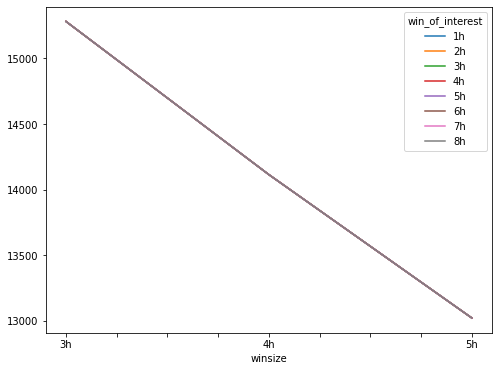

In [51]:
df_result = []
delta = "0h"
for winsize in winsizes:
    for win_of_interest in wins_of_interest:
        data = load_data(winsize, delta, win_of_interest)
        row = {}
        row["win_of_interest"] = win_of_interest
        row["delta"] = delta
        row["winsize"] = winsize
        row["total_number_examples"] = data.shape[0]
        df_result.append(row)
    
pd.DataFrame(df_result).pivot(index="winsize", values="total_number_examples", columns="win_of_interest").plot()

### Testing how good the classification task can be

In [57]:
def get_feature_mapping(signals, data):

    feature_mapping = {}
    mapped_feature = set([])

    for feature in signals:
        for k in data.keys():
            if k.startswith(feature):
                if feature not in feature_mapping:
                    feature_mapping[feature] = []
                feature_mapping[feature].append(k)            
                mapped_feature.add(k)

    feature_mapping["other"] = []
    for k in data.keys():
        if k not in mapped_feature and k not in ['pid', 'ground_truth', 'gt_time']:
            feature_mapping["other"].append(k)

    return feature_mapping

feature_mapping = get_feature_mapping(signals, data)

In [63]:
def map_id_fold(all_ids, n, pid_col="pid"):
    
    pids = all_ids[pid_col].unique().ravel()
    if n < 0:
        n = len(pids)
    
    kf = KFold(n_splits=n, shuffle=True, random_state=42)
    mapping = []
    for i, (_, test) in enumerate(kf.split(pids)):
        for pid_index in test:
            mapping.append({'fold': i, pid_col: pids[pid_index]})

    return pd.DataFrame(mapping)

In [186]:
def classification_both_hyper_hypo(row):
    if is_hyper(cgm_value):
        return 1
    elif is_hypo(cgm_value):
        return 2
    return 0

def test_classification(gt_strategy, winsize, delta, win_of_interest, featset):
            
    data = load_data(winsize, delta, win_of_interest)
    
    if gt_strategy == "hyper":
        data["ground_truth"] = data["hyper"] > 0
    elif gt_strategy == "hypo":
        data["ground_truth"] = data["hypo"] > 0
    elif gt_strategy == "both":
        data["ground_truth"] = data[["hyper", "hypo"]].apply(lambda x: 0 if x["hyper"] == 0 and x["hypo"] == 0 else
                                                                       1 if x["hyper"] > 0 and x["hypo"] == 0 else
                                                                       2 if x["hypo"] > 0 and x["hyper"] == 0 else
                                                                       3, axis=1)
    
    feature_mapping = get_feature_mapping(featset, data)
    df_folds = map_id_fold(data, -1)
    data = data.merge(df_folds)

    train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
    test_fold = train_data["fold"].max()
    test_data = train_data[train_data["fold"] == test_fold]
    train_data = train_data[train_data["fold"] != test_fold]

    cv = GroupKFold() #### <---- This is extremely important to avoid auto-correlation between the train/test

    experiment = setup(data = train_data, test_data = test_data,
                   target='ground_truth', session_id=42, silent=True,
                   fold_strategy = cv, fold_groups = 'fold',
                   ignore_features = ["pid", "time", "fold", "Diabetes Medication", "hyper", "hypo"]
                  )
    
    best_model = compare_models(include=['lightgbm', 'lr', 'et'], n_select=1)
    best_model = create_model(best_model)
    
    #best_model = create_model("lightgbm")
    train_result = pull()
    prediction_results = predict_model(best_model)
    test_result = pull()
    
    return train_result, test_result


In [187]:
# data distribution:
# 0    0.521041
# 1    0.341038
# 2    0.115113
# 3    0.022808
# 0    6785
# 1    4441
# 2    1499
# 3     297

In [188]:

delta = "0h"
featset = ['time','mets', "HeartRate", 'Calories', 'Steps', 'Distance', 'CGM', 'other']
params = []

for winsize in winsizes:
    for win_of_interest in wins_of_interest:
        for gt_strategy in ["hyper", "hypo", "both"]:
            params.append([winsize, win_of_interest, gt_strategy])
            
rows = []
for param in params:
    winsize, win_of_interest, gt_strategy = param
    
    train_results, test_results = test_classification(gt_strategy, winsize, delta, win_of_interest, featset)
    row = {}
    row["winsize"] = winsize
    row["win_of_interest"] = win_of_interest
    row["gt_strategy"] = gt_strategy
    row["delta"] = delta
    row["featset"] = "_".join(sorted(featset))
    row["delta"] = delta
    row["model"] = test_results["Model"].values[0]
    for m in ["Accuracy", "AUC", "Recall", "Prec.", "F1", "Kappa", "MCC"]:
        row["%s_test" % (m)] = test_results[m].values[0]
        row["%s_train" % (m)] = train_results.loc["Mean"][m]
        
    rows.append(row)
    
pd.DataFrame(rows)

create_model_container: 4
master_model_container: 4
display_container: 3
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)
create_model() succesfully completed......................................
Initializing predict_model()
predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_sp

winsize win_of_interest gt_strategy delta  \
0       5h              5h       hyper    0h   
1       5h              5h        hypo    0h   
2       5h              5h        both    0h   
3       5h              1h       hyper    0h   
4       5h              1h        hypo    0h   
..     ...             ...         ...   ...   
67      4h              7h        hypo    0h   
68      4h              7h        both    0h   
69      4h              8h       hyper    0h   
70      4h              8h        hypo    0h   
71      4h              8h        both    0h   

                                              featset  \
0   CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
1   CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
2   CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
3   CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
4   CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
..                                                ...   
67  CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
68  CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
69  CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
70  CGM_Calories_Distance_HeartRate_Steps_mets_oth...   
71  CGM_Calories_Distance_HeartRate_Steps_mets_oth...   

                              model  Accuracy_test  Accuracy_train  AUC_test  \
0            Extra Trees Classifier         0.7232          0.6881    0.7592   
1               Logistic Regression         0.9426          0.8767    0.5000   
2            Extra Trees Classifier         0.6831          0.5700    0.0000   
3   Light Gradient Boosting Machine         0.9382          0.9160    0.9216   
4   Light Gradient Boosting Machine         0.9886          0.9409    0.9058   
..                              ...            ...             ...       ...   
67              Logistic Regression         0.9266          0.8528    0.5000   
68           Extra Trees Classifier         0.5959          0.4687    0.7031   
69  Light Gradient Boosting Machine         0.6763          0.5580    0.8022   
70              Logistic Regression         0.9166          0.8446    0.5000   
71           Extra Trees Classifier         0.5694          0.4512    0.0000   

    AUC_train  Recall_test  Recall_train  Prec._test  Prec._train  F1_test  \
0      0.6948       0.2457        0.3980      0.8298       0.6688   0.3791   
1      0.5000       0.0000        0.0000      0.0000       0.0000   0.0000   
2      0.6696       0.3013        0.3147      0.6339       0.5724   0.6144   
3      0.9402       0.6250        0.6666      0.8989       0.9016   0.7373   
4      0.9243       0.2308        0.2959      0.8571       0.8326   0.3636   
..        ...          ...           ...         ...          ...      ...   
67     0.5000       0.0000        0.0000      0.0000       0.0000   0.0000   
68     0.6192       0.2846        0.2871      0.5312       0.4984   0.5285   
69     0.6849       0.3426        0.5102      0.8438       0.6415   0.4873   
70     0.5000       0.0000        0.0000      0.0000       0.0000   0.0000   
71     0.6442       0.2849        0.2937      0.5268       0.5163   0.4931   

    F1_train  Kappa_test  Kappa_train  MCC_test  MCC_train  
0     0.4715      0.2633       0.2694    0.3444     0.3102  
1     0.0000      0.0000       0.0000    0.0000     0.0000  
2     0.5293      0.2234       0.1892    0.2833     0.2256  
3     0.7578      0.7036       0.7037    0.7185     0.7229  
4     0.4178      0.3598       0.4046    0.4414     0.4667  
..       ...         ...          ...       ...        ...  
67    0.0000      0.0000       0.0000    0.0000     0.0000  
68    0.4451      0.1398       0.1012    0.1686     0.1160  
69    0.4407      0.3078       0.1834    0.3748     0.2171  
70    0.0000      0.0000       0.0000    0.0000     0.0000  
71    0.4157      0.1286       0.1064    0.1691     0.1381  

[72 rows x 20 columns]

In [67]:
winsizes = ["5h", "3h", "4h", ]
deltas = ["0h"]
wins_of_interest = ["5h", "1h", "2h", "3h", "4h", "6h", "7h", "8h"]

data = None

params = []
for winsize in winsizes:
    for delta in deltas:
        for win_of_interest in wins_of_interest:
            params.append([winsize, delta, win_of_interest])

    
print("Macro F1: %.2f, Micro F1: %.2f, Prec: %.2f, Recall: %.2f, MCC: %.2f" % (f1_mac, f1_mic, prec, recall, mcc))


create_model_container: 13
master_model_container: 13
display_container: 2
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
compare_models() succesfully completed......................................


In [131]:


df_timeseries, df_labels, df_label_time, df_pids = generate_timeseries_df_from_block(df, signals, winsize="5h", delta="0h", win_of_interest="5h")

for col in ["hyper", "hypo"]:
    del df_timeseries[col]
    
features_filtered = extract_features_from_df(df_timeseries, df_labels["hyper"] > 0, winsize="5h", delta="0h", win_of_interest="5h")

100%|██████████| 14/14 [01:03<00:00,  4.51s/it]


In [258]:
data = pd.concat([df_pids, df_labels, df_label_time, features_filtered], axis=1)

# Add Ramadan and time flags
data["ramadan"] = data["gt_time"].apply(lambda x: ramadan_flag(x))
data = pd.merge(data, df[["patientID", "time", "time_sin", "time_cos"]], left_on=["pid", "gt_time"], right_on=["patientID", "time"])

# Add EMR data
data = data.merge(df_emr, left_on="pid", right_index=True)

print("Note that there were many NAN in the ERM files.")
print("If we dropall NAN, we go from %d rows to %d (i.e., from %d to %d participants)" % (data.shape[0], 
                                                                                          data.dropna().shape[0],
                                                                                          data["pid"].unique().shape[0],
                                                                                          data.dropna()["pid"].unique().shape[0]))

print("So, lets dropping NAs...")

data = data.dropna()
save_data(data, winsize="5h", delta="0h", win_of_interest="5h")

Note that there were many NAN in the ERM files.
If we dropall NAN, we go from 19930 rows to 13022 (i.e., from 12 to 8 participants)
So, lets dropping NAs...


Next we map all features to a dictionary called feature_mapping. 
Later, this will help us to build models using different feature sets.
Example ``model(data[feature_mapping["Steps"]])`` would create a model only using "Steps".

In [267]:
df_emr.keys() # ["Cholesterol"]# astype(np.float)

Index(['BMI', 'Cholesterol', 'Creatinine', 'Diabetes Duration',
       'Diabetes Medication', 'Diastolic Blood Pressure', 'HDL', 'HbA1c',
       'LDL', 'Systolic Blood Pressure', 'Triglyceride', 'Metformin',
       'Glargine', 'Pioglitazone', 'Dulaglutide', 'Vildagliptin',
       'Liraglutide', 'Glicalzide', 'Dapagliflozin', 'Glimepride', 'Degludec',
       'Aspart', 'Exenatide', 'Sitagliptin', 'Empagliflozin'],
      dtype='object', name='variable')

In [268]:
data[["pid", "ground_truth"] + feature_mapping["Steps"]].head(5)

pid  ground_truth  \
1213   39          True   
1214   39          True   
1215   39          True   
1216   39          True   
1217   39          True   

      Steps__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)  \
1213                                           0.000000                
1214                                           0.000000                
1215                                         392.886612                
1216                                         412.695340                
1217                                         442.800561                

      Steps__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"  \
1213                                          -0.707107                   
1214                                          -0.707107                   
1215                                           0.380921                   
1216                                           0.639136                   
1217                                           0.888358                   

      Steps__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"  \
1213                                           0.000000                  
1214                                           0.000000                  
1215                                          10.045895                  
1216                                           4.212679                  
1217                                          13.896282                  

      Steps__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"  \
1213                                           0.000000                   
1214                                           0.000000                   
1215                                           9.237604                   
1216                                          12.413031                   
1217                                          40.125844                   

      Steps__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)  \
1213                                           0.000000                
1214                                           0.000000                
1215                                         387.820274                
1216                                         408.323830                
1217                                         438.643004                

      Steps__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)  \
1213                                           0.000000                
1214                                           0.000000                
1215                                         360.180171                
1216                                         370.209398                
1217                                         405.075731                

      Steps__linear_trend__attr_"rvalue"  \
1213                           -0.295420   
1214                           -0.332347   
1215                            0.269053   
1216                            0.435422   
1217                            0.491050   

      Steps__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"  ...  \
1213                                          -0.866025                   ...   
1214                                          -0.866025                   ...   
1215                                           0.672961                   ...   
1216                                           0.925733                   ...   
1217                                           0.965765                   ...   

      Steps__quantile__q_0.2  Steps__permutation_entropy__dimension_6__tau_1  \
1213                     0.0                                        0.688567   
1214                     0.0                                        0.463414   
1215                    76.0                                        2.772589   
1216                    76.0                                        2.772589   
1217                    78.0                 

In [270]:
df_folds = map_id_fold(data, -1)
df_folds.head(10)

fold  pid
0     0   50
1     1   75
2     2   39
3     3   81
4     4   53
5     5   58
6     6   54
7     7   79

In [271]:
data = data.merge(df_folds)
data.head()

pid  hyper  hypo             gt_time  \
0   39   13.0   0.0 2020-02-19 05:00:00   
1   39   13.0   0.0 2020-02-19 05:15:00   
2   39    6.0   0.0 2020-02-19 10:45:00   
3   39    5.0   0.0 2020-02-19 11:00:00   
4   39    4.0   0.0 2020-02-19 11:15:00   

   CGM__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)  CGM__maximum  \
0                                         406.136580                    203.0   
1                                         388.878975                    203.0   
2                                         589.226385                    226.0   
3                                         591.426822                    226.0   
4                                         591.354073                    226.0   

   CGM__minimum  CGM__cwt_coefficients__coeff_8__w_20__widths_(2, 5, 10, 20)  \
0          93.0                                         494.326791             
1          93.0                                         485.549546             
2         124.0                                         616.606049             
3         131.0                                         627.148752             
4         136.0                                         636.779697             

   CGM__cwt_coefficients__coeff_7__w_20__widths_(2, 5, 10, 20)  \
0                                         481.610928             
1                                         473.573752             
2                                         587.239007             
3                                         597.958390             
4                                         607.448403             

   CGM__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)  ...  \
0                                         466.515579            ...   
1                                         459.521088            ...   
2                                         555.700103            ...   
3                                         567.390165            ...   
4                                         576.989049            ...   

   Dapagliflozin  Glimepride  Degludec  Aspart  Exenatide  Sitagliptin  \
0          False       False     False   False      False         True   
1          False       False     False   False      False         True   
2          False       False     False   False      False         True   
3          False       False     False   False      False         True   
4          False       False     False   False      False         True   

   Empagliflozin  ground_truth  time_weekend  fold  
0          False          True         False     2  
1          False          True         False     2  
2          False          True         False     2  
3          False          True         False     2  
4          False          True         False     2  

[5 rows x 1425 columns]

In [54]:
def get_cols_by_featureset(data, featset, feature_mapping):
    acc_feats = []
    for f in featset:
        acc_feats.extend(feature_mapping[f])
        
    return ["pid", "ground_truth", "fold"] + acc_feats


In [273]:
def get_classification_results_from_regression(df_test, cgm_gt="ground_truth", cgm_predicted="Label"):
    
    df = df_test.copy()
    
    df["class_gt"] = df[cgm_gt].apply(lambda x: hyper_hypo_label(x))
    df["class_predicted"] = df[cgm_predicted].apply(lambda x: hyper_hypo_label(x))

    cf_matrix = metrics.confusion_matrix(df["class_gt"], df["class_predicted"])
    cf_matrix = pd.DataFrame(cf_matrix, index=["Normal", "Hyper", "Hypo"], columns=["Normal", "Hyper", "Hypo"])
    fig = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
    
    f1_mac = metrics.f1_score(df["class_gt"], df["class_predicted"], average="macro")
    f1_mic = metrics.f1_score(df["class_gt"], df["class_predicted"], average="micro")
    prec = metrics.precision_score(df["class_gt"], df["class_predicted"], average="weighted")
    recall = metrics.recall_score(df["class_gt"], df["class_predicted"], average="weighted")
    mcc = metrics.matthews_corrcoef(df["class_gt"], df["class_predicted"])
    
    
    return f1_mac, f1_mic, prec, recall, mcc, fig
# 

In [274]:
feature_sets = [
    ['time','mets', 'Calories', 'Steps', 'Distance', 'CGM', 'other'],
    ['time', 'mets', 'Calories', 'Steps', 'Distance', 'CGM'],
    ['time','mets', 'Calories', 'Steps', 'Distance', 'other'],                 
    ['time','mets', 'Calories', 'Steps', 'Distance'], 
    ]

This experiment takes only one participant as test:

In [298]:
#data["ground_truth"] = data["hyper"] > 0
data["ground_truth"] = data["hypo"] > 0

In [55]:
featset = feature_sets[0]
winsize = "5h"
delta = "0h"
win_of_interest = "5h"

#data = load_data(winsize, delta)
#feature_mapping = get_feature_mapping(signals, data)
#df_folds = map_id_fold(data, -1)
#data = data.merge(df_folds)
        
train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
test_fold = train_data["fold"].max()
test_data = train_data[train_data["fold"] == test_fold]
train_data = train_data[train_data["fold"] != test_fold]

cv = GroupKFold() #### <---- This is extremely important to avoid auto-correlation between the train/test

experiment = setup(data = train_data, test_data = test_data,
                   target='ground_truth', session_id=42, silent=True,
                   fold_strategy = cv, fold_groups = 'fold',
                   ignore_features = ["pid", "time", "fold", "Diabetes Medication"]
                  )
best_model = compare_models()

#best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
#create_model(best_model)
#train_result = pull()

#test_result = predict_model(best_model)
#f1_mac, f1_mic, prec, recall, mcc, fig = get_classification_results_from_regression(test_result)

#print("Macro F1: %.2f, Micro F1: %.2f, Prec: %.2f, Recall: %.2f, MCC: %.2f" % (f1_mac, f1_mic, prec, recall, mcc))
#fig

NameError: name 'feature_sets' is not defined

In [305]:
feature_set = feature_sets[0]
winsize = "3h"
delta = "1h"

data = load_data(winsize, delta)
feature_mapping = get_feature_mapping(signals, data)
df_folds = map_id_fold(data, -1)
data = data.merge(df_folds)
        
train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
test_fold = train_data["fold"].max()
test_data = train_data[train_data["fold"] == test_fold]
train_data = train_data[train_data["fold"] != test_fold]

cv = GroupKFold() #### <---- This is extremely important to avoid auto-correlation between the train/test

experiment = setup(data = train_data, test_data = test_data,
                   target='ground_truth', session_id=42, silent=True,
                   fold_strategy = cv, fold_groups = 'fold',
                   ignore_features = ["pid", "time", "fold"]
                  )

best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
create_model(best_model)
train_result = pull()

test_result = predict_model(best_model)
f1_mac, f1_mic, prec, recall, mcc, fig = get_classification_results_from_regression(test_result)

print("Macro F1: %.2f, Micro F1: %.2f, Prec: %.2f, Recall: %.2f, MCC: %.2f" % (f1_mac, f1_mic, prec, recall, mcc))
fig

create_model_container: 4
master_model_container: 4
display_container: 3
OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)
create_model() succesfully completed......................................
Initializing predict_model()
predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
Checking exceptions
Preloading libraries
Preparing display monitor


NameError: name 'hyper_hypo_label' is not defined

In [307]:
predict_model(best_model)

Initializing predict_model()
predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
Checking exceptions
Preloading libraries
Preparing display monitor


time_sin  time_cos  \
0     0.866025  0.500000   
1     0.896873  0.442289   
2     0.923880  0.382683   
3     0.946930  0.321439   
4     0.965926  0.258819   
...        ...       ...   
2036 -0.382683  0.923880   
2037 -0.321439  0.946930   
2038 -0.258819  0.965926   
2039 -0.195090  0.980785   
2040 -0.130526  0.991445   

      mets__cwt_coefficients__coeff_12__w_5__widths_(2 5 10 20)  \
0                                            192.861893           
1                                            192.152664           
2                                            193.126526           
3                                            193.466797           
4                                            192.972961           
...                                                 ...           
2036                                         683.895142           
2037                                         621.676636           
2038                                         479.838440           
2039                                         356.374878           
2040                                         256.894379           

      mets__cwt_coefficients__coeff_11__w_5__widths_(2 5 10 20)  \
0                                            249.514099           
1                                            247.975540           
2                                            247.266327           
3                                            248.240173           
4                                            248.215454           
...                                                 ...           
2036                                         854.827698           
2037                                         818.576843           
2038                                         695.404846           
2039                                         556.851562           
2040                                         426.818146           

      mets__cwt_coefficients__coeff_10__w_5__widths_(2 5 10 20)  \
0                                            297.543304           
1                                            294.930176           
2                                            293.391602           
3                                            292.682404           
4                                            293.355469           
...                                                 ...           
2036                                         972.484253           
2037                                         965.811340           
2038                                         879.332153           
2039                                         758.867065           
2040                                         614.899902           

      mets__agg_linear_trend__attr_slope__chunk_len_10__f_agg_min  \
0                                                   0.0             
1                                                   1.0             
2                                                   1.0             
3                                                   1.0             
4                                                   0.0             
...                                                 ...             
2036                                               54.0             
2037                                               54.0             
2038                                               12.0             
2039                                               12.0             
2040                                              -51.0             

      mets__cwt_coefficients__coeff_9__w_5__widths_(2 5 10 20)  \
0                                            331.309540          
1                                            328.853149          
2                                            326.240021          
3                                            324.701447          
4                                            323.784882          
...                          

create_model_container: 4
master_model_container: 4
display_container: 3
OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)
create_model() succesfully completed......................................
Initializing predict_model()
predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
Checking exceptions
Preloading libraries
Preparing display monitor


Macro F1: 0.48, Micro F1: 0.92, Prec: 0.90, Recall: 0.92, MCC: 0.32


<AxesSubplot:>

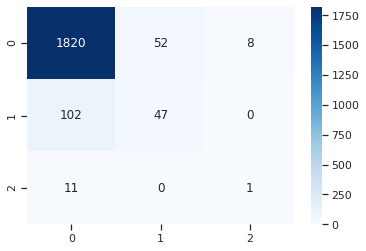

In [343]:
feature_set = feature_sets[0]
winsize = "3h"
delta = "1h"

data = load_data(winsize, delta)
feature_mapping = get_feature_mapping(signals, data)
df_folds = map_id_fold(data, -1)
data = data.merge(df_folds)
        
train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
test_fold = train_data["fold"].max()
test_data = train_data[train_data["fold"] == test_fold]
train_data = train_data[train_data["fold"] != test_fold]

cv = GroupKFold() #### <---- This is extremely important to avoid auto-correlation between the train/test

experiment = setup(data = train_data, test_data = test_data,
                   target='ground_truth', session_id=42, silent=True,
                   # fold_strategy = cv, fold_groups = 'fold', <<<--- Not using it anymore
                   ignore_features = ["pid", "time", "fold"]
                  )

best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
create_model(best_model)
train_result = pull()

test_result = predict_model(best_model)
f1_mac, f1_mic, prec, recall, mcc, fig = get_classification_results_from_regression(test_result)

print("Macro F1: %.2f, Micro F1: %.2f, Prec: %.2f, Recall: %.2f, MCC: %.2f" % (f1_mac, f1_mic, prec, recall, mcc))
fig

This next experiment does what needs to be done correctly:
It takes one participant at time as a test and accumulates the results

create_model_container: 4
master_model_container: 4
display_container: 3
OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)
create_model() succesfully completed......................................
Initializing predict_model()
predict_model(estimator=OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
Checking exceptions
Preloading libraries
Preparing display monitor


Macro F1: 0.56, Micro F1: 0.87, Prec: 0.85, Recall: 0.87, MCC: 0.47


<AxesSubplot:>

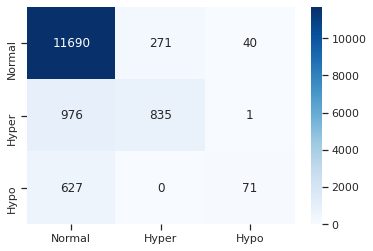

In [377]:
feature_set = feature_sets[0]
winsize = "3h"
delta = "1h"

data = load_data(winsize, delta)
feature_mapping = get_feature_mapping(signals, data)
df_folds = map_id_fold(data, -1)
data = data.merge(df_folds)

test_results = []
        
for test_fold in data["fold"].unique():
    
    train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
    test_data = train_data[train_data["fold"] == test_fold]
    train_data = train_data[train_data["fold"] != test_fold]

    cv = GroupKFold() #### <---- This is extremely important to avoid auto-correlation between the train/test

    experiment = setup(data = train_data, test_data = test_data,
                       target='ground_truth', session_id=42, silent=True,
                       fold_strategy = cv, fold_groups = 'fold',
                       ignore_features = ["pid", "time", "fold"]
                      )
    best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
    create_model(best_model)
    training_result = pull()

    test_result = predict_model(best_model)
    test_results.append(test_result[["ground_truth", "Label"]])
    
test_results = pd.concat(test_results)    
f1_mac, f1_mic, prec, recall, mcc, fig = get_classification_results_from_regression(test_results)

print("Macro F1: %.2f, Micro F1: %.2f, Prec: %.2f, Recall: %.2f, MCC: %.2f" % (f1_mac, f1_mic, prec, recall, mcc))
fig

In [242]:
# Experiment with different data frames at the same time:
feature_set = ['time','mets', 'Calories', 'Steps', 'Distance', 'CGM', 'other']  

results = []

for winsize in winsizes:
    for delta in deltas:
        data = load_data(winsize, delta)
        feature_mapping = get_feature_mapping(signals, data)
        df_folds = map_id_fold(data, -1)
        data = data.merge(df_folds)
        
        for test_fold in range(train_data["fold"].unique()):
        
            train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
            test_data = train_data[train_data["fold"] == test_fold]
            train_data = train_data[train_data["fold"] != test_fold]

            cv = GroupKFold()

            experiment = setup(data = train_data, test_data = test_data,
                               target='ground_truth', session_id=42, silent=True,
                               fold_strategy = cv, fold_groups = 'fold',
                               ignore_features = ["pid", "time", "fold"]
                              )

            best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
            create_model(best_model)
            training_result = pull()

            row = {}
            row["delta"] = delta
            row["winsize"] = winsize
            row["featset"] = featset
            row["training_r2"] = training_result.loc["Mean"]["R2"]
            row["training_rmse"] = training_result.loc["Mean"]["RMSE"]
            row["name"] = best_model

            predict_model(best_model)["r2"]
            result = pull()
            row["test_r2"] = training_result.loc["Mean"]["R2"]
            row["test_rmse"] = training_result.loc["Mean"]["RMSE"]
            row["test_fold"] = test_fold
            
            results.append(row)

pd.DataFrame(results)

create_model_container: 4
master_model_container: 4
display_container: 3
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=42, verbose=False)
create_model() succesfully completed......................................


delta winsize                                            featset      r2  \
0     1h      1h  [time, mets, Calories, Steps, Distance, CGM, o... -0.3881   
1     2h      1h  [time, mets, Calories, Steps, Distance, CGM, o...  0.1361   
2     3h      1h  [time, mets, Calories, Steps, Distance, CGM, o... -0.3943   
3     1h      2h  [time, mets, Calories, Steps, Distance, CGM, o...  0.4643   
4     2h      2h  [time, mets, Calories, Steps, Distance, CGM, o... -0.2525   
5     3h      2h  [time, mets, Calories, Steps, Distance, CGM, o... -0.2369   
6     1h      3h  [time, mets, Calories, Steps, Distance, CGM, o...  0.4658   
7     2h      3h  [time, mets, Calories, Steps, Distance, CGM, o... -0.0560   
8     3h      3h  [time, mets, Calories, Steps, Distance, CGM, o... -0.1380   
9     1h      4h  [time, mets, Calories, Steps, Distance, CGM, o...  0.3362   
10    2h      4h  [time, mets, Calories, Steps, Distance, CGM, o... -0.1167   
11    3h      4h  [time, mets, Calories, Steps, Distance, CGM, o... -0.3195   
12    1h      5h  [time, mets, Calories, Steps, Distance, CGM, o... -0.3655   
13    2h      5h  [time, mets, Calories, Steps, Distance, CGM, o... -0.3685   
14    3h      5h  [time, mets, Calories, Steps, Distance, CGM, o... -0.3618   

       rmse                                               name  
0   47.7006  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...  
1   37.1815  OrthogonalMatchingPursuit(fit_intercept=True, ...  
2   47.4019  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...  
3   29.0417  OrthogonalMatchingPursuit(fit_intercept=True, ...  
4   44.4776  OrthogonalMatchingPursuit(fit_intercept=True, ...  
5   43.7006  OrthogonalMatchingPursuit(fit_intercept=True, ...  
6   28.6333  OrthogonalMatchingPursuit(fit_intercept=True, ...  
7   40.0562  OrthogonalMatchingPursuit(fit_intercept=True, ...  
8   42.5299  OrthogonalMatchingPursuit(fit_intercept=True, ...  
9   29.3161  OrthogonalMatchingPursuit(fit_intercept=True, ...  
10  40.6832  OrthogonalMatchingPursuit(fit_intercept=True, ...  
11  45.5909  OrthogonalMatchingPursuit(fit_intercept=True, ...  
12  45.5107  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...  
13  46.1022  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...  
14  46.8815  LassoLars(alpha=1.0, copy_X=True, eps=2.220446...

<AxesSubplot:xlabel='winsize'>

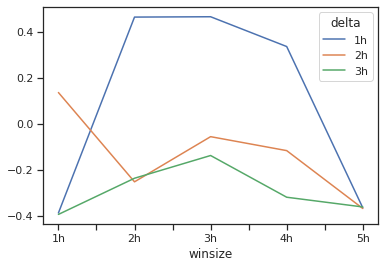

In [249]:
predictions = pd.DataFrame(results)
predictions.pivot(index="winsize", values="r2", columns="delta").plot()

create_model_container: 4
master_model_container: 4
display_container: 3
LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=42, verbose=False)
create_model() succesfully completed......................................
Initializing predict_model()
predict_model(estimator=LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, jitter=None, max_iter=500, normalize=True,
          positive=False, precompute='auto', random_state=42, verbose=False), probability_threshold=None, encoded_labels=True, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None)
Checking exceptions
Preloading libraries
Preparing display monitor


ValueError: Shape of passed values is (2, 2), indices imply (3, 3)

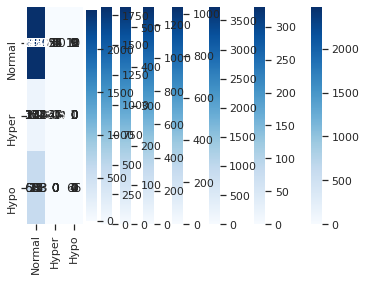

In [385]:
# Experiment with different data frames at the same time:
feature_set = ['time','mets', 'Calories', 'Steps', 'Distance', 'CGM', 'other']  

results = []

for winsize in ["3h"]: # winsizes:
    for delta in deltas:
        data = load_data(winsize, delta)
        feature_mapping = get_feature_mapping(signals, data)
        df_folds = map_id_fold(data, -1)
        data = data.merge(df_folds)
        
        for test_fold in train_data["fold"].unique():
        
            train_data = data[get_cols_by_featureset(data, featset, feature_mapping)]
            test_data = train_data[train_data["fold"] == test_fold]
            train_data = train_data[train_data["fold"] != test_fold]

            cv = GroupKFold()

            experiment = setup(data = train_data, test_data = test_data,
                               target='ground_truth', session_id=42, silent=True,
                               fold_strategy = cv, fold_groups = 'fold',
                               ignore_features = ["pid", "time", "fold"]
                              )

            best_model = compare_models(include=['llar', 'lr', 'omp'], n_select=1)
            create_model(best_model)
            training_result = pull()

            row = {}
            row["delta"] = delta
            row["winsize"] = winsize
            row["featset"] = featset
            row["training_r2"] = training_result.loc["Mean"]["R2"]
            row["training_rmse"] = training_result.loc["Mean"]["RMSE"]
            row["training_mae"] = training_result.loc["Mean"]["MAE"]
            row["name"] = best_model

            predictions = predict_model(best_model)
            test_result = pull()
            row["test_r2"] = test_result["R2"].values[0]
            row["test_rmse"] = test_result["RMSE"].values[0]
            row["test_mae"] = test_result["MAE"].values[0]
            row["test_fold"] = test_fold
            
            f1_mac, f1_mic, prec, recall, mcc, fig = get_classification_results_from_regression(predictions)
            row["test_f1_mac"] = f1_mac
            row["test_f1_mic"] = f1_mic
            row["test_prec"] = prec
            row["test_recall"] = recall
            row["test_mcc"] = mcc
            
            results.append(row)
            
pd.DataFrame(results)